# Monitoreo de Espacios Verdes - 1

## Descarga de imágenes

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
#
import os
import matplotlib.pyplot as plt
import geopandas as gpd

#
from eo_tilematcher import intersects, get_spacecraft_db

#
from eo_forge.utils.downloader import gcSatImg
from eo_forge.utils.downloader import bucket_images_downloader

## Determinacion de Tile a Descargar

Para ello usamos una libreria que nos permite conocer en que tile esta una dada zona de interes

In [2]:
sentinel2_tiles = get_spacecraft_db("sentinel2")

### Cordoba

In [3]:
gpd_roi = gpd.read_file("../data/cba/cordoba.geojson")
#
sentinel_match = intersects("sentinel2", gpd_roi)
display(sentinel_match)

,geometry,match_polygon,match,TILE
0,"POLYGON ((-64.31465 -31.50421, -64.04686 -31.5...",POLYGON Z ((-64.31465148925781 -31.27796401330...,total,20JLL


Text(0.5, 1.0, 'Cordoba in Sentinel Tile 20JLL')

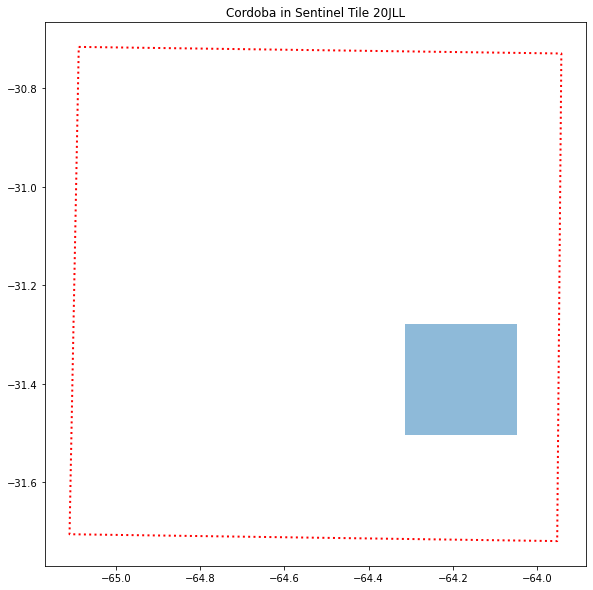

In [4]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sentinel_match.plot(ax=ax, edgecolor="None", alpha=0.5)
tile = "20JLL"  ## Fill with TILE
sentinel2_tiles[sentinel2_tiles.TILE == tile].plot(
    ax=ax, facecolor="None", edgecolor="r", lw=2, ls=":"
)
ax.set_title(f"Cordoba in Sentinel Tile {tile}")

## Descarga

Para la descarga podemos usar (entre otros):
- [sentinelsat](https://github.com/sentinelsat/sentinelsat).
- [_eo_forge_](https://eo-forge.readthedocs.io/en/latest/) 

Sugerimos empezar con _sentinelsat_ (solo hay que generar una cuenta en [scihub](https://scihub.copernicus.eu/).)

En lo que sigue mostramos el correspondiente a [_eo_forge_](https://eo-forge.readthedocs.io/en/latest/reference/utils.html#downloader-module). Para ello sugerimos primero generar el archivo de configuracion correspondiente (revisar paso siguiente)

### Archivos de Configuracion - [Google Cloud](https://cloud.google.com/storage/docs/public-datasets/sentinel-2)


Google provee acceso gratuito a imagenes de Sentinel 2. En [url](https://cloud.google.com/storage/docs/public-datasets/sentinel-2) podemos obtener un _gzip_ con todas las imagenes y sus respectivos paths (aunque esto lo podemos resolver de otra forma, tambien).

Cualquiera sea el camino debemos obtener un archivo de configuracion que nos permite la descarga.

#### Generacion de .boto


**NOTA**: Actualmente se requiere una autorizacion para descargar las imagenes. El ambiente generado ya debe tener instalado _gsutil_ por lo que activamos el ambiente  y en la linea la linea de comandos (bash, powershell, cmd,etc):


``` > gsutil config```


Esto mostrara un mensaje y un link. Seguir el link y darle acceso a gsutil a una cuenta de gmail. 
Seguidamente copiar el codigo y pegarlo en la linea de comandos. Cuando pregunte por un ID de proyecto simplemente intoducir 0 y esperar. Esto generará 
un Boto config file @ 
-  linux: '$HOME/.boto' .
-  windows: %USERPROFILE%\\.boto


### Cordoba

Veamos un caso ejemplo

In [ ]:
s2 = gcSatImg(spacecraft="S2")

In [ ]:
# esto lo obtuvimos con eo_tilematcher
s2.gcImagesCheck(["20", "J", "LL"])

In [ ]:
s2.gcImagesFilt(filters=[], dates=["2017-01-01", "2022-04-20"])

In [ ]:
MAX_CLOUD_COVER = 80

In [ ]:
pd_filt = s2.pd_filt.copy()
pd_filt["clouds"] = pd_filt["clouds"].astype(float)
pd_filt = pd_filt[pd_filt["clouds"] < MAX_CLOUD_COVER]
pd_filt.drop_duplicates("date", inplace=True)
#
pd_filt.sort_values("date", inplace=True)

In [ ]:
# filt arbitrario por orbita relativa
pd_ = pd_filt[pd_filt["product-id"].str.contains("R010")].copy()

In [ ]:
pd_.reset_index(drop=True, inplace=True)

In [ ]:
pd_.to_csv("../data/cba/productos-descargados-cba.cvs")

In [ ]:
pd_to_download = pd_.copy()
pd_to_download

In [ ]:
BANDS = ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B08", "B11", "B12"]

In [ ]:
IMAGES_RAW = "/data/sat-images/sentinel2/"

In [ ]:
bid = bucket_images_downloader(spacecraft="S2", bands=BANDS)
bid.execute(
    pd_to_download["base-url"].to_list(),
    archive=IMAGES_RAW,
    max_proc_thread=5,
    force_download=False,
)